In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import cvxpy as cp
import osqp
from scipy import sparse
import matplotlib.pyplot as plt
import os

In [2]:
STD_WINDOW_SIZE = 20
WINDOW = 120
REBALANCE_PERIOD = 20

In [3]:
def rolling_markowitz(returns, window=120, rebalance_period=20):
    """
    Rolling Markowitz Optimization to maximize Sharpe ratio with periodic rebalancing.
    Args:
        returns (pd.DataFrame): DataFrame of asset returns.
        window (int): Look-back period for the rolling window.
        rebalance_period (int): Number of days between rebalancing (e.g., 20 for monthly rebalancing).
    Returns:
        net_returns_series (pd.Series): Daily portfolio returns over time.
        weights_history (list): List of optimal weights at each rebalancing step.
        annualized_return (float): Annualized return of the portfolio.
        annualized_volatility (float): Annualized volatility of the portfolio.
        sharpe_ratio (float): Sharpe ratio of the portfolio.
    """
    # Define a range of target returns to search for the maximum Sharpe ratio
    target_returns = np.linspace(0.05 / 252, 0.30 / 252, 26)  # Convert annual returns to daily returns

    net_returns = []
    weights_history = []
    last_valid_weights = None

    for i in range(window + STD_WINDOW_SIZE - 1, len(returns) - 1):
        # Rebalance only every 'rebalance_period' days
        if (i - window + 1) % rebalance_period == 0:
            # Rolling window data for the past 'window' days
            window_data = returns.iloc[i - window:i]
            mu = window_data.mean().values
            Sigma = window_data.cov().values

            n_assets = len(mu)
            best_sharpe_ratio = -np.inf
            best_weights = None

            # Iterate over the target returns to find the maximum Sharpe ratio
            for target_return in target_returns:
                w = cp.Variable(n_assets)
                portfolio_variance = cp.quad_form(w, Sigma)
                portfolio_return = mu.T @ w

                # Define constraints for the target return
                constraints = [
                    cp.sum(w) == 1,                # Weights sum to 1
                    w >= 0,                        # No short-selling
                    portfolio_return >= target_return  # Achieve the target return
                ]

                # Minimize the portfolio variance
                objective = cp.Minimize(portfolio_variance)
                prob = cp.Problem(objective, constraints)

                # Solve the optimization problem
                result = prob.solve()

                if w.value is not None:
                    weights = w.value
                    # Calculate the expected return and volatility
                    expected_return = mu.T @ weights
                    expected_volatility = np.sqrt(weights.T @ Sigma @ weights)

                    # Calculate the Sharpe ratio (assuming a risk-free rate of 0)
                    sharpe_ratio = expected_return / expected_volatility if expected_volatility != 0 else np.nan

                    # Update the best Sharpe ratio and corresponding weights
                    if sharpe_ratio > best_sharpe_ratio:
                        best_sharpe_ratio = sharpe_ratio
                        best_weights = weights

            # Use the best weights found or fallback to the last valid weights
            if best_weights is not None:
                last_valid_weights = best_weights
                weights_history.append(best_weights)
            else:
                best_weights = last_valid_weights
                weights_history.append(best_weights)

        else:
            # Use the last valid weights if it's not a rebalancing day
            best_weights = last_valid_weights

        if best_weights is None:
            continue

        # Ensure weights are valid (clip and normalize)
        best_weights = np.clip(best_weights, 0, 1)
        best_weights /= best_weights.sum()

        # Calculate the portfolio return for the next day using these weights
        next_day_return = np.dot(best_weights, returns.iloc[i + 1].values)
        net_returns.append(next_day_return)

    # Convert net returns to a pandas Series
    portfolio_returns = pd.Series(net_returns, index=returns.index[window + STD_WINDOW_SIZE:])

    # Calculate annualized return, annualized volatility, and Sharpe ratio
    total_period_return = portfolio_returns.mean() * 252  # Average daily return annualized
    annualized_return = total_period_return

    # Annualized volatility (standard deviation of daily returns, annualized)
    annualized_volatility = np.std(portfolio_returns) * np.sqrt(252)

    # Sharpe ratio (assuming a risk-free rate of 0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    return portfolio_returns, weights_history, annualized_return, annualized_volatility, sharpe_ratio


In [4]:
def rolling_minimum_variance_portfolio(returns, window=120, rebalance_period=20):
    """
    Rolling Minimum Variance Portfolio with periodic rebalancing.
    Args:
        returns (pd.DataFrame): DataFrame of asset returns.
        window (int): Look-back period.
        rebalance_period (int): Number of days between rebalancing (e.g., 20 for monthly rebalancing).
    Returns:
        portfolio_returns (pd.Series): Daily portfolio returns over time.
        weights_history (list): List of optimal weights at each rebalancing step.
        annualized_return (float): Annualized return of the portfolio.
        annualized_volatility (float): Annualized volatility of the portfolio.
        sharpe_ratio (float): Sharpe ratio of the portfolio.
    """
    portfolio_returns = []
    weights_history = []
    last_valid_weights = None

    for i in range(window + STD_WINDOW_SIZE - 1, len(returns) - 1):
        # Rebalance only every 'rebalance_period' days
        if (i - window + 1) % rebalance_period == 0:
            # Rolling window data for the past 'window' days
            window_data = returns.iloc[i - window:i]
            Sigma = window_data.cov().values

            n_assets = Sigma.shape[0]

            # Define the optimization problem using cvxpy
            w = cp.Variable(n_assets)
            portfolio_variance = cp.quad_form(w, Sigma)

            # Define constraints without a target return
            constraints = [
                cp.sum(w) == 1,  # Weights sum to 1
                w >= 0           # No short-selling
            ]

            objective = cp.Minimize(portfolio_variance)
            prob = cp.Problem(objective, constraints)

            result = prob.solve()

            if w.value is not None:
                weights = w.value
                last_valid_weights = weights  # Update last valid weights
                weights_history.append(weights)  # Store valid weights
            else:
                print(f"Optimization failed at index {i}. Using last valid weights.")
                weights = last_valid_weights
                weights_history.append(weights)
        else:
            # Use the last valid weights if it's not a rebalancing day
            weights = last_valid_weights

        if weights is None:
            continue

        weights = np.clip(weights, 0, 1)       # Clip weights to ensure they are within bounds
        weights /= weights.sum()               # Normalize to ensure they sum to 1

        # Calculate the portfolio return for the next day using these weights
        next_day_return = np.dot(weights, returns.iloc[i + 1].values)
        portfolio_returns.append(next_day_return)

    # Convert portfolio returns to a pandas Series
    portfolio_returns_series = pd.Series(portfolio_returns, index=returns.index[window + STD_WINDOW_SIZE:])

    # Calculate annualized return, annualized volatility, and Sharpe ratio
    total_period_return = portfolio_returns_series.mean() * 252  # Average daily return annualized
    annualized_return = total_period_return

    # Annualized volatility (standard deviation of daily returns, annualized)
    annualized_volatility = np.std(portfolio_returns_series) * np.sqrt(252)

    # Sharpe ratio (assuming a risk-free rate of 0)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else np.nan

    return portfolio_returns_series, weights_history, annualized_return, annualized_volatility, sharpe_ratio

In [5]:
def calculate_max_drawdown(returns):
    """
    Calculate the maximum drawdown from a series of returns.
    Handles potential numerical issues and invalid values.
    Args:
        returns (array-like): Daily or periodic returns of a portfolio.
    Returns:
        max_drawdown (float): Maximum drawdown (as a positive number).
    """
    # Ensure returns are a numpy array
    returns = np.array(returns)
    
    # Remove invalid values
    returns = returns[np.isfinite(returns)]

    # Handle edge case: if no valid returns, return NaN
    if len(returns) == 0:
        return np.nan

    # Calculate cumulative returns
    cumulative_returns = np.cumprod(1 + returns)

    # Clip cumulative returns to avoid numerical overflow
    cumulative_returns = np.clip(cumulative_returns, a_min=1e-10, a_max=1e10)

    # Calculate the running peak
    peak = np.maximum.accumulate(cumulative_returns)

    # Calculate drawdown
    drawdown = (cumulative_returns - peak) / peak

    # Calculate maximum drawdown (most negative drawdown value)
    max_drawdown = np.min(drawdown)

    # Return the absolute value of the maximum drawdown
    return abs(max_drawdown)

In [6]:
# Parameters
start_analysis_date = "2015-01-01"

# Define tickers
tickers = {
    'XLF': 'XLF',   # Financials Select Sector SPDR Fund
    'XLK': 'XLK',   # Technology Select Sector SPDR Fund
    'XLE': 'XLE',   # Energy Select Sector SPDR Fund
    'XLP': 'XLP',   # Consumer Staples Select Sector SPDR Fund
    'XLY': 'XLY',   # Consumer Discretionary Select Sector SPDR Fund
    'XLU': 'XLU',   # Utilities Select Sector SPDR Fund
    'XLI': 'XLI',   # Industrials Select Sector SPDR Fund
    'XLV': 'XLV',   # Health Care Select Sector SPDR Fund
    'VNQ': 'VNQ',   # Vanguard Real Estate ETF
    'IYZ': 'IYZ',   # iShares U.S. Telecommunications ETF
    'XBI': 'XBI',   # SPDR S&P Biotech ETF
    'XOP': 'XOP',   # SPDR S&P Oil & Gas Exploration ETF
    'ITA': 'ITA',   # iShares U.S. Aerospace & Defense ETF
    'KBE': 'KBE'    # SPDR S&P Bank ETF
}

# Import data starting well before the analysis start date (e.g., 5 years prior)
extra_data_start_date = "2014-01-01"  # Import more data than necessary
data = yf.download(list(tickers.values()), start=extra_data_start_date, end="2023-12-31")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Print data summary
print("Data Start Date:", returns.index.min())
print("Data End Date:", returns.index.max())
print("Total Days in Dataset:", len(returns))

# Convert start_analysis_date to pandas Timestamp to ensure format consistency
start_analysis_date = pd.Timestamp(start_analysis_date)

# Ensure the index is timezone-naive for consistency
returns.index = returns.index.tz_localize(None)

# Find the index of the closest date before or equal to the start_analysis_date
if start_analysis_date not in returns.index:
    start_analysis_date = returns.index.asof(start_analysis_date)

analysis_index = returns.index.get_loc(start_analysis_date)

# Compute the index for the look-back start date
lookback_start_index = analysis_index - (WINDOW + STD_WINDOW_SIZE - 1)

# Validate the computed index
if lookback_start_index < 0:
    raise ValueError("Not enough data available for the look-back period!")

print("Lookback Start Index:", lookback_start_index)
print("Analysis Index:", analysis_index)

[*********************100%***********************]  14 of 14 completed

Data Start Date: 2014-01-03 00:00:00+00:00
Data End Date: 2023-12-29 00:00:00+00:00
Total Days in Dataset: 2515
Lookback Start Index: 111
Analysis Index: 250


In [7]:
# Get the look-back start date from the index
lookback_start_date = returns.index[lookback_start_index]

# Filter the data to include the necessary look-back period
filtered_returns = returns.loc[lookback_start_date:]

# Confirm the new range
print(f"Filtered Data Start Date (includes look-back): {filtered_returns.index.min()}")
print(f"Filtered Data End Date: {filtered_returns.index.max()}")

Filtered Data Start Date (includes look-back): 2014-06-13 00:00:00
Filtered Data End Date: 2023-12-29 00:00:00


In [8]:
filtered_returns

Ticker,ITA,IYZ,KBE,VNQ,XBI,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,XOP
Date,,,,,,,,,,,,,,
2014-06-13,0.002438,0.013979,-0.001208,0.002560,-0.003898,0.009539,0.000442,0.003498,0.005803,-0.000224,0.006386,-0.000838,0.000456,0.011531
2014-06-16,0.001442,-0.003026,-0.006048,-0.005107,0.018688,0.005995,-0.004865,-0.001101,0.000000,0.003803,0.006816,0.002012,0.002280,0.002603
2014-06-17,-0.001440,0.003710,0.017037,0.002567,0.002053,-0.000707,0.010222,0.002755,0.002360,0.000000,-0.001401,-0.000502,0.003943,0.001730
2014-06-18,0.001893,0.013105,0.004188,0.007006,0.011434,0.007580,0.005719,0.005679,0.005233,0.011809,0.022674,0.008038,0.007553,0.010734
2014-06-19,-0.000360,0.001658,-0.004170,0.008296,0.001895,0.007122,-0.001312,0.002550,-0.001822,0.005726,0.008229,0.003322,-0.002399,0.010132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.005751,0.006732,0.004589,0.003891,0.034841,0.002951,0.002147,0.004796,0.001303,0.007640,0.003365,0.004987,-0.007356,0.002309
2023-12-26,0.005400,0.008025,0.013270,0.007411,0.021000,0.008590,0.004017,0.007071,0.004166,0.004212,0.006068,0.002222,0.004234,0.015696
2023-12-27,0.000632,0.001769,-0.000859,0.004866,0.015314,-0.004433,0.003201,0.001492,-0.000052,0.004614,-0.000635,0.004212,0.003440,-0.004182


In [9]:
# Define the date range for the analysis
start_date = "2015-01-01"
end_date = "2023-12-31"

# Filter the returns to the desired date range
equal_returns = returns.loc[start_date:end_date]

# Number of assets
num_assets = len(equal_returns.columns)

# Assign equal weights to all assets
equal_weights = np.ones(num_assets) / num_assets

# Compute equal-weighted portfolio returns
portfolio_returns_equal = equal_returns.dot(equal_weights)

# Annualized metrics (assuming 252 trading days per year)
annualized_return_equal = portfolio_returns_equal.mean() * 252
annualized_volatility_equal = portfolio_returns_equal.std() * np.sqrt(252)
sharpe_ratio_equal = annualized_return_equal / annualized_volatility_equal if annualized_volatility_equal != 0 else np.nan

In [10]:
# Run the rolling Markowitz optimization
portfolio_returns_marko, weights_history_marko, annualized_return_marko, annualized_volatility_marko, sharpe_ratio_marko = rolling_markowitz(
    filtered_returns, window=WINDOW, rebalance_period=REBALANCE_PERIOD
)

# Run the rolling minimum variance portfolio
portfolio_returns_mv, weights_history_mv, annualized_return_mv, annualized_volatility_mv, sharpe_ratio_mv = rolling_minimum_variance_portfolio(
    filtered_returns, window=WINDOW, rebalance_period=REBALANCE_PERIOD
)

In [11]:
# Calculate cumulative returns from portfolio returns
cumulative_returns_equal = (1 + portfolio_returns_equal).cumprod() - 1

# Calculate max drawdown and Calmar ratio for the Markowitz portfolio
max_drawdown_equal = calculate_max_drawdown(portfolio_returns_equal)
calmar_ratio_equal = annualized_return_equal / max_drawdown_equal if max_drawdown_equal != 0 else np.nan

# Display the results
print("Final Cumulative Return from Equal Weight Portfolio:")
print(1 + cumulative_returns_equal.iloc[-1])  # Final cumulative return
print("Days: ", len(cumulative_returns_equal))

print("\nAnnualized Return:", annualized_return_equal)
print("Annualized Volatility:", annualized_volatility_equal)
print("Sharpe Ratio:", sharpe_ratio_equal)
print("Max Drawdown:", max_drawdown_equal)
print("Calmar Ratio:", calmar_ratio_equal)

print("-" * 60)

# Calculate cumulative returns from portfolio returns
cumulative_returns_marko = (1 + portfolio_returns_marko).cumprod() - 1

# Calculate max drawdown and Calmar ratio for the Markowitz portfolio
max_drawdown_marko = calculate_max_drawdown(portfolio_returns_marko)
calmar_ratio_marko = annualized_return_marko / max_drawdown_marko if max_drawdown_marko != 0 else np.nan

# Display the results
print("Final Cumulative Return from Rolling Markowitz Portfolio:")
print(1 + cumulative_returns_marko.iloc[-1])  # Final cumulative return
print("Days: ", len(cumulative_returns_marko))

print("\nAnnualized Return:", annualized_return_marko)
print("Annualized Volatility:", annualized_volatility_marko)
print("Sharpe Ratio:", sharpe_ratio_marko)
print("Max Drawdown:", max_drawdown_marko)
print("Calmar Ratio:", calmar_ratio_marko)

if weights_history_marko:
    print("Weight Length: ", len(weights_history_marko))
else:
    print("\nNo valid weights were generated during the optimization process.")

print("-" * 60)

# Calculate cumulative returns from portfolio returns
cumulative_returns_mv = (1 + portfolio_returns_mv).cumprod() - 1

# Calculate max drawdown and Calmar ratio for the minimum variance portfolio
max_drawdown_mv = calculate_max_drawdown(portfolio_returns_mv)
calmar_ratio_mv = annualized_return_mv / max_drawdown_mv if max_drawdown_mv != 0 else np.nan

# Display the results
print("Final Cumulative Return from Rolling Minimum Variance Portfolio:")
print(1 + cumulative_returns_mv.iloc[-1])  # Final cumulative return
print("Days: ", len(cumulative_returns_mv))

print("\nAnnualized Return:", annualized_return_mv)
print("Annualized Volatility:", annualized_volatility_mv)
print("Sharpe Ratio:", sharpe_ratio_mv)
print("Max Drawdown:", max_drawdown_mv)
print("Calmar Ratio:", calmar_ratio_mv)

if weights_history_mv:
    print("Weight Length: ", len(weights_history_mv))
else:
    print("\nNo valid weights were generated during the optimization process.")

Final Cumulative Return from Equal Weight Portfolio:
2.1393562814812976
Days:  2264

Annualized Return: 0.10322193851585146
Annualized Volatility: 0.19208914074461342
Sharpe Ratio: 0.5373647782259967
Max Drawdown: 0.39792608881311453
Calmar Ratio: 0.25939977653571117
------------------------------------------------------------
Final Cumulative Return from Rolling Markowitz Portfolio:
1.518047556450613
Days:  2264

Annualized Return: 0.06358711925583367
Annualized Volatility: 0.18445879233756818
Sharpe Ratio: 0.3447226258505818
Max Drawdown: 0.3240221497216034
Calmar Ratio: 0.19624312507792163
Weight Length:  114
------------------------------------------------------------
Final Cumulative Return from Rolling Minimum Variance Portfolio:
1.8629128395506338
Days:  2264

Annualized Return: 0.08024749480931125
Annualized Volatility: 0.14792544932948867
Sharpe Ratio: 0.5424860642509743
Max Drawdown: 0.29966904294596225
Calmar Ratio: 0.26778706942973035
Weight Length:  114


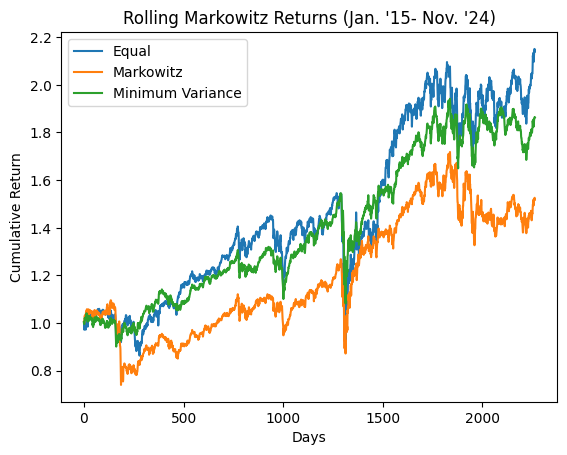

In [12]:
plt.plot(range(len(cumulative_returns_equal)), cumulative_returns_equal + 1, label="Equal")
plt.plot(range(len(cumulative_returns_marko)), cumulative_returns_marko + 1, label="Markowitz")
plt.plot(range(len(cumulative_returns_mv)), cumulative_returns_mv + 1, label="Minimum Variance")
plt.xlabel("Days")
plt.ylabel("Cumulative Return")
plt.legend()
plt.title("Rolling Markowitz Returns (Jan. \'15- Nov. \'24)")
plt.show()

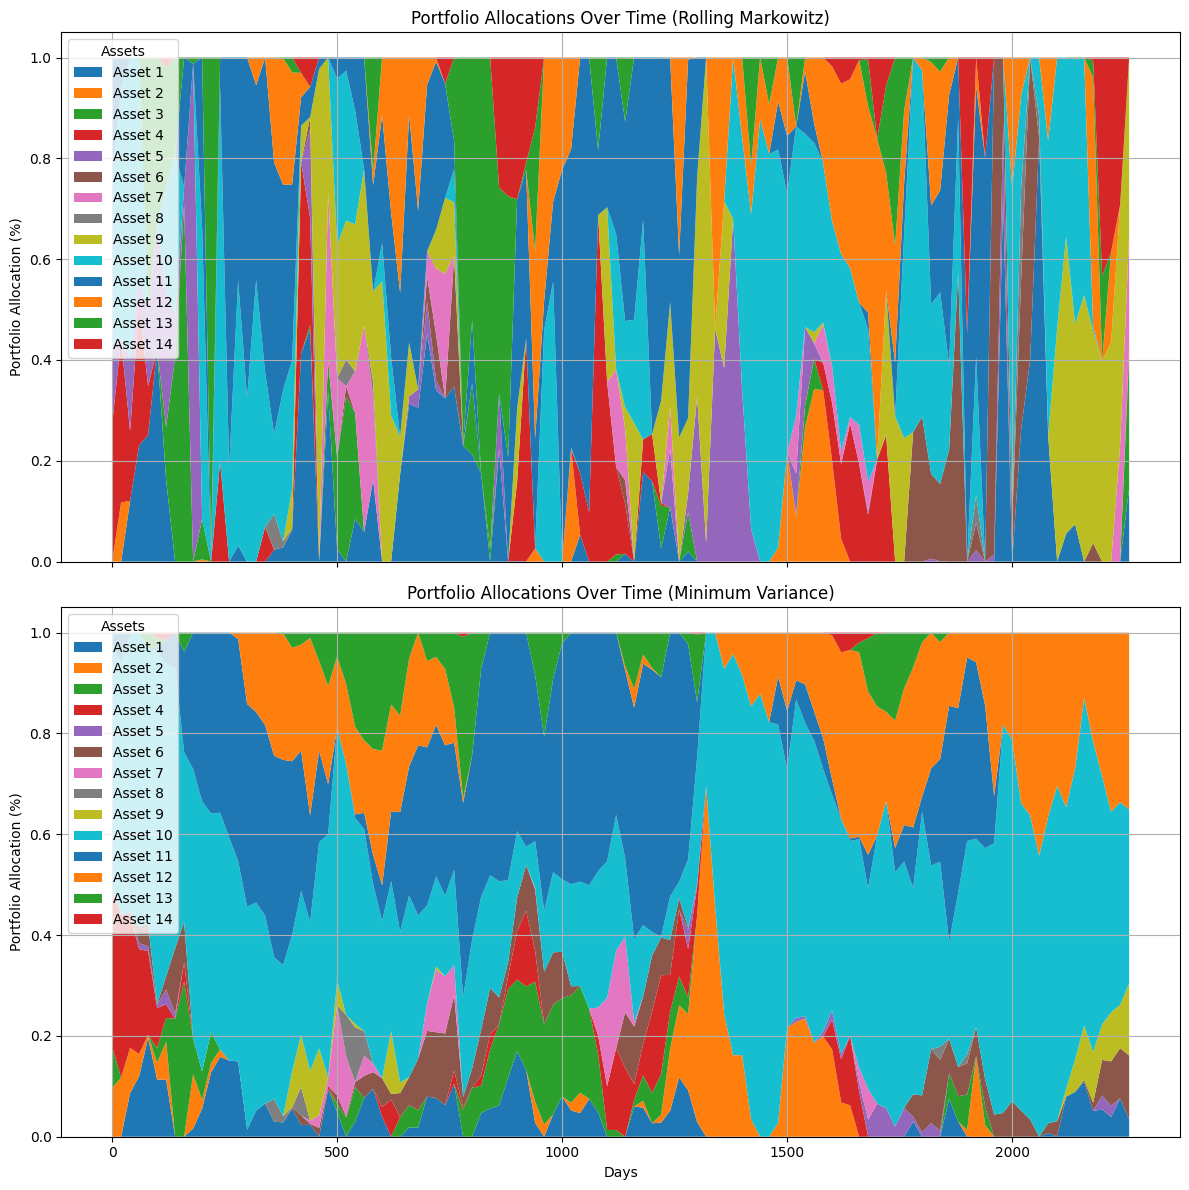

In [15]:
# Convert the weight history to NumPy arrays
weights_history_marko = np.array(weights_history_marko)
weights_history_mv = np.array(weights_history_mv)

# Define the asset names and x-axis values
num_rebalancing_periods_marko, num_assets_marko = weights_history_marko.shape
num_rebalancing_periods_mv, num_assets_mv = weights_history_mv.shape
asset_names = [f"Asset {i + 1}" for i in range(num_assets_marko)]  # Replace with `tickers` if you have it
x_values_marko = np.arange(num_rebalancing_periods_marko) * REBALANCE_PERIOD
x_values_mv = np.arange(num_rebalancing_periods_mv) * REBALANCE_PERIOD

# Create a figure with two stacked subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# Plot the "Rolling Markowitz" allocations
axes[0].stackplot(x_values_marko, weights_history_marko.T, labels=asset_names)
axes[0].set_title("Portfolio Allocations Over Time (Rolling Markowitz)")
axes[0].set_ylabel("Portfolio Allocation (%)")
axes[0].legend(title="Assets", loc="upper left")
axes[0].grid()

# Plot the "Minimum Variance" allocations
axes[1].stackplot(x_values_mv, weights_history_mv.T, labels=asset_names)
axes[1].set_title("Portfolio Allocations Over Time (Minimum Variance)")
axes[1].set_xlabel("Days")
axes[1].set_ylabel("Portfolio Allocation (%)")
axes[1].legend(title="Assets", loc="upper left")
axes[1].grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [16]:
# Create a directory to save the data if it doesn't exist
output_dir = "stats"
os.makedirs(output_dir, exist_ok=True)

# Save portfolio_returns_marko
np.save(os.path.join(output_dir, "portfolio_returns_marko.npy"), portfolio_returns_marko)

# Save portfolio_returns_mv
np.save(os.path.join(output_dir, "portfolio_returns_mv.npy"), portfolio_returns_mv)

# Save equal_returns
np.save(os.path.join(output_dir, "portfolio_returns_equal.npy"), portfolio_returns_equal)

print(f"Exported portfolio returns to the '{output_dir}' folder.")

Exported portfolio returns to the 'stats' folder.
